In [2]:
#hide
! [ -e /content ]
!pip install -Uqq fastbook fastai


In [3]:
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.PASCAL_2007)

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [6]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [7]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [8]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [9]:
tmp_df['d'] = tmp_df['a'] + tmp_df['b']
tmp_df

,a,b,d
0,1,3,4
1,2,4,6


In [10]:
dblock = DataBlock()

In [11]:
dsets = dblock.datasets(df)

In [12]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [14]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [15]:
# by default the dataset is just the DataFrames (not dep and indep variables)
# We have to explicitly specify the dep/indep variables
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [16]:
# the more explicit approach is better than lambda functions
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [17]:
# We can see that the independent variable will need to be converted into a complete path, 
# so that we can open it as an image, and the dependent variable will need to be split on the space character 
# (which is the default for Python’s split function) so that it becomes a list:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

In [18]:
# to convert the dataset into tensors we need to use a set of transforms for (dep, indep)
# CategoryBlock will not work for multi-label so we need to use MultiCategoryBlock with by default takes a list of labels
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y
)
dsets = dblock.datasets(df)
dsets.train[0]
# the DataBlock cannot just use integers to specify the label because tensors have to be the same length
# this is why TensorMultiCategory uses a list of every possible label with `1` for every respective label for that image
# and 0 for every label that does not represent that given image
                   

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [19]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [25]:
def custom_splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=custom_splitter,
    item_tfms=RandomResizedCrop(128, min_scale=0.35)
)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

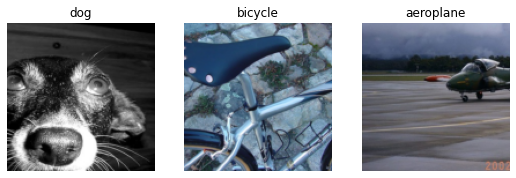

In [26]:
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

In [27]:
learn = vision_learner(dls, resnet18)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [28]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [29]:
activs[0]

TensorBase([ 0.5674, -1.2013,  4.5409, -1.5284, -0.6600,  0.0999, -2.4757, -0.8773, -0.2934, -1.4746, -0.1738,  2.1763, -3.4473, -1.1407,  0.1783, -1.6922, -2.3396,  0.7602, -1.4213, -0.4334],
           grad_fn=<AliasBackward0>)

In [30]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0367, grad_fn=<AliasBackward0>)

In [31]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=.2)).to_fp16()
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)
        

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.944328,0.700234,0.237092,00:25
1,0.823248,0.552861,0.299522,00:23
2,0.601400,0.199268,0.820637,00:23
3,0.358978,0.122619,0.944442,00:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136990,0.115866,0.945199,00:28
1,0.118202,0.103729,0.951673,00:28
2,0.098872,0.101750,0.951255,00:28


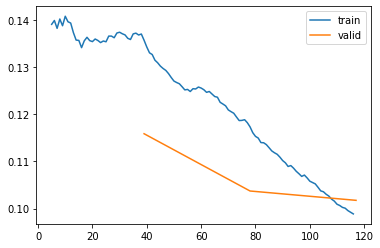

In [32]:
learn.recorder.plot_loss()

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused()

[('bicycle', 'aeroplane', 1338), ('aeroplane', 'bicycle', 491)]

In [36]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10174991935491562,0.9289839863777161]

In [37]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10174991935491562,0.9423906207084656]

In [40]:
preds, targs = learn.get_preds()

In [41]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9565)

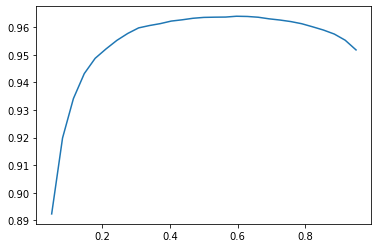

In [43]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [44]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [45]:
#hide
Path.BASE_PATH = path

In [46]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [47]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [48]:
img_files = get_image_files(path)
def img2pose(x): 
    return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('16/frame_00831_pose.txt')

In [50]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

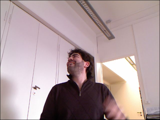

In [51]:
im.to_thumb(160)

In [56]:
# this function returns the coordinates of the head as a tensor of two items
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [57]:
get_ctr(img_files[0])

tensor([312.9687, 239.5307])

In [58]:
# PointBlock lets fastai know that the labels are coordinates (of the center of the head in this case)
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms = aug_transforms(size=(240,320))
)

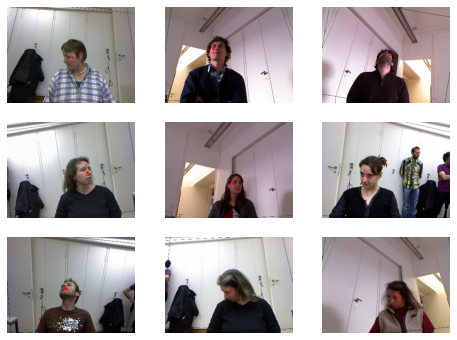

In [59]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [60]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [66]:
learn = vision_learner(dls, resnet18, y_range=(-1,1)).to_fp16()

SuggestedLRs(valley=0.001737800776027143)

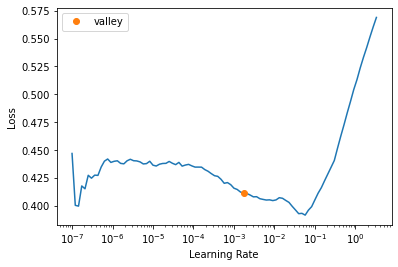

In [67]:
learn.lr_find()

In [69]:
learn.fine_tune(3, 3e-2)

epoch,train_loss,valid_loss,time
0,0.042226,0.005969,02:33


epoch,train_loss,valid_loss,time
0,0.003454,0.000520,03:28
1,0.001876,0.000162,03:28
2,0.001195,0.000159,03:28


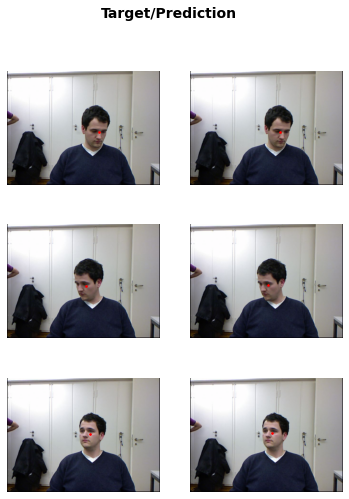

In [70]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))